# News Headlines Topic Modeling Analysis

This notebook focuses on analyzing news headlines using Natural Language Processing (NLP) to:
1. Identify common keywords and phrases
2. Extract significant events and topics
3. Track how topics evolve over time

We'll use Latent Dirichlet Allocation (LDA) combined with specific event detection to understand what our news headlines are discussing.

In [1]:
import pandas as pd
import numpy as np 
import os 
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.topic_modeling import (
    make_vectorizer,
    build_dtm,
    run_lda,
    top_keywords_per_topic,
    get_document_topics
)

## Data Loading

We'll use the cleaned news headlines dataset that we prepared in our EDA notebook.

In [2]:
cleaned_filtered_data = pd.read_csv("../Data/cleaned/cleaned_filtered_news.csv")
print(f"Loaded {len(cleaned_filtered_data)} headlines")

# Display sample headlines
print("\nSample Headlines:")
print(cleaned_filtered_data['headline'].sample(5).to_list())

Loaded 7261 headlines

Sample Headlines:
['Bernstein Upgrades NVIDIA to Outperform, Raises Price Target to $360', 'Airline Shares Jump As Stimulus Agreement Offers Relief, While Nike Up On Earnings', 'Shares of several communication and media companies are trading lower amid continued spread of coronavirus including notable upticks in Iran and Italy. NOTE: The virus has raised fear of a global economic slowdown.', 'Google Asks All North American Employees To Work From Home As Coronavirus Spreads', 'Morgan Stanley Maintains Underweight on NVIDIA, Raises PT to $21.00']


## Event Detection Framework

Before applying topic modeling, we'll first look for specific, important events in our headlines.
This helps us identify concrete instances of significant events like "FDA approval" or "price target changes".

In [3]:
# Define specific events to track
key_events = {
    'price_targets': ['price target', 'raises target', 'lowers target', 'upgrades', 'downgrades'],
    'fda_related': ['fda approval', 'fda clears', 'clinical trial', 'drug approval'],
    'earnings': ['beats earnings', 'misses earnings', 'earnings preview', 'quarterly results'],
    'leadership': ['ceo', 'executive changes', 'board member', 'management'],
    'product': ['launches', 'announces', 'unveils', 'releases']
}

# Analyze headlines for specific events
print("Analyzing Headlines for Specific Events:")
event_counts = {event: 0 for event in key_events}
headline_events = []

for headline in cleaned_filtered_data['headline']:
    headline_lower = headline.lower()
    found_events = []
    
    for event, phrases in key_events.items():
        if any(phrase in headline_lower for phrase in phrases):
            event_counts[event] += 1
            found_events.append(event)
    
    headline_events.append(found_events)

# Add events to dataframe
cleaned_filtered_data['specific_events'] = headline_events

# Show event statistics
print("\nFrequency of Specific Events:")
for event, count in event_counts.items():
    print(f"{event}: {count} headlines")

# Show example headlines for each event type
print("\nExample Headlines by Event Type:")
for event in key_events:
    event_headlines = cleaned_filtered_data[
        cleaned_filtered_data['specific_events'].apply(lambda x: event in x)
    ]['headline'].sample(min(3, event_counts[event]))
    
    print(f"\n{event.replace('_', ' ').title()}:")
    for headline in event_headlines:
        print(f"- {headline}")

Analyzing Headlines for Specific Events:

Frequency of Specific Events:
price_targets: 775 headlines
fda_related: 0 headlines
earnings: 26 headlines
leadership: 129 headlines
product: 172 headlines

Example Headlines by Event Type:

Price Targets:
- Barclays Maintains Equal-Weight on NVIDIA, Raises Price Target to $225.00
- Goldman Sachs Initiates Coverage On Tesla with Buy Rating, Announces Price Target to $864
- Morgan Stanley Upgrades AMD, Says 'Table Is Set Well' For 2020

Fda Related:

Earnings:
- Nvidia Q1 Earnings Preview: Data Center, Gaming Inventory In Focus Amid Fundamental Uncertainties
- Big Chip Q3 Earnings Preview: Intel Could Win On Muted Expectations, AMD Makes Inroads
- Tesla Q4 Earnings Preview: Can The Good News Keep Coming?

Leadership:
- Facebook Shares At Pre-Market Low, Down 1.8%, As CEO Mark Zuckerberg Begins Interview On CNBC
- Nvidia CEO Sees 50% Growth in Tegra Revenue This Year
- Microsoft CEO Criticizes India's Exclusionary Citizenship Law, Compares To US 

## Topic Modeling Analysis

Now we'll use LDA to discover broader themes and patterns in our headlines.
This will help us understand the general topics being discussed, beyond specific events.

In [4]:
# Step 1: Convert headlines to numerical format
print("Converting headlines to numerical format...")
vectorizer = make_vectorizer(method='tfidf', max_features=5000)
dtm, feature_names = build_dtm(cleaned_filtered_data['headline'].tolist(), vectorizer)

# Step 2: Run LDA to discover topics
print("\nDiscovering topics...")
n_topics = 15  # Number of topics to discover
lda_model = run_lda(dtm, num_topics=n_topics)

# Step 3: Get the main words for each topic
topics = top_keywords_per_topic(lda_model, feature_names, n_top=15)

# Print discovered topics
print("\nDiscovered Topics:")
for idx, topic_words in enumerate(topics):
    print(f"\nTopic {idx + 1}:")
    print(f"Keywords: {', '.join(topic_words)}")

Converting headlines to numerical format...

Discovering topics...

Discovered Topics:

Topic 1:
Keywords: tesla, biggest, changes, musk, price, elon, electrek, target, model, 10, says, china, electric, production, friday

Topic 2:
Keywords: trade, tesla, china, devices, google, says, advanced, purchases, etf, huge, micro, amazon, car, new, share

Topic 3:
Keywords: nvidia, citron, tesla, goldman, deutsche, services, graphics, says, amd, left, bank, cramer, sachs, communication, new

Topic 4:
Keywords: upgrades, downgrades, nvidia, benzinga, morgan, stanley, buy, pt, bank, hold, initiates, coverage, america, 00, corporation

Topic 5:
Keywords: tesla, street, model, google, nvidia, earnings, investor, year, wall, deliveries, movement, semiconductor, coronavirus, index, starts

Topic 6:
Keywords: media, social, google, cloud, dow, nvidia, crude, etf, trump, gaming, video, executive, games, house, afternoon

Topic 7:
Keywords: target, price, maintains, raises, nvidia, buy, outperform, low

## Topic Assignment Analysis

Let's examine how these topics appear in our headlines and how they relate to our specific events.

In [5]:
# Assign topics to headlines
doc_topics = get_document_topics(lda_model, dtm)
cleaned_filtered_data['topics'] = doc_topics

# Show example headlines with their topics and events
print("Example Headlines with Topics and Events:")
for _, row in cleaned_filtered_data.sample(5).iterrows():
    print(f"\nHeadline: {row['headline']}")
    print(f"Assigned Topics: {[i+1 for i in row['topics']]}")
    print("Topic Keywords:")
    for topic_idx in row['topics']:
        print(f"- Topic {topic_idx + 1}: {', '.join(topics[topic_idx][:5])}")
    if row['specific_events']:
        print(f"Specific Events Found: {row['specific_events']}")

# Show topic assignment statistics
topic_counts = cleaned_filtered_data['topics'].apply(len).value_counts()
print("\nTopic Assignment Statistics:")
print(f"Headlines with single topic: {topic_counts[1]}")
print(f"Headlines with multiple topics: {sum(topic_counts[topic_counts > 1])}")

Example Headlines with Topics and Events:

Headline: A Peek Into The Markets: US Stock Futures Edge Lower Following Monday's Rally
Assigned Topics: [11]
Topic Keywords:
- Topic 11: shares, trading, higher, stock, lower

Headline: Today's Pickup: Aerial Vs. Ground Autonomous Transportation
Assigned Topics: [2]
Topic Keywords:
- Topic 2: trade, tesla, china, devices, google

Headline: UPDATE: Cowen On Tesla Notes 'Despite commentary earlier this year suggesting a smoothing of deliveries throughout the quarter, Tesla appears to continue to stress its logistics for end of quarter surges'
Assigned Topics: [3]
Topic Keywords:
- Topic 3: nvidia, citron, tesla, goldman, deutsche

Headline: Analysts Upbeat On AMD's Product Roadmap, Execution
Assigned Topics: [7]
Topic Keywords:
- Topic 7: target, price, maintains, raises, nvidia

Headline: UPDATE: Morgan Stanley Downgrades Tesla To Underweight, Raises Target To $360 'based on (1) valuation, (2) unfavorable risk-reward, and (3) risks to the long

## Temporal Analysis

Finally, let's analyze how our topics and events evolve over time.

In [6]:
# Add year information
cleaned_filtered_data['year'] = pd.to_datetime(cleaned_filtered_data['date']).dt.year

# Analyze topics and events over time
print("Topic and Event Evolution by Company:")
for company in cleaned_filtered_data['stock'].unique():
    company_data = cleaned_filtered_data[cleaned_filtered_data['stock'] == company]
    print(f"\n{company}:")
    
    # Group by year
    yearly_data = company_data.groupby('year')
    
    for year, year_data in yearly_data:
        print(f"\nYear {year}:")
        # Show topics
        year_topics = set([topic for topics in year_data['topics'] for topic in topics])
        print("Topics:", [i+1 for i in year_topics])
        
        # Show specific events
        year_events = set([event for events in year_data['specific_events'] for event in events])
        if year_events:
            print("Specific Events:", list(year_events))

# Save results
cleaned_filtered_data.to_csv("../Data/cleaned/analyzed/tech_news_with_topics_and_events.csv", index=False)

Topic and Event Evolution by Company:

MSF:

Year 2010:
Topics: [10]

Year 2016:
Topics: [5]

NVDA:

Year 2011:
Topics: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Specific Events: ['earnings', 'product', 'price_targets', 'leadership']

Year 2012:
Topics: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Specific Events: ['product', 'price_targets', 'leadership']

Year 2013:
Topics: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Specific Events: ['earnings', 'product', 'price_targets', 'leadership']

Year 2014:
Topics: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Specific Events: ['product', 'price_targets']

Year 2015:
Topics: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Specific Events: ['product', 'price_targets', 'leadership']

Year 2016:
Topics: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Specific Events: ['earnings', 'product', 'price_targets', 'leadership']

Year 2017:
Topics: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Specific Event

In [7]:
cleaned_filtered_data

,Unnamed: 0,headline,url,publisher,date,stock,specific_events,topics,year
0,861780,4-6-10 Daily Small Cap Market News and Stock H...,https://www.benzinga.com/208992/4-6-10-daily-s...,SmallCapVoice,2010-04-06,MSF,[],[9],2010
1,932188,Nvidia Goes Negative (NVDA),https://www.benzinga.com/market-update/11/03/9...,Scott Rubin,2011-03-03,NVDA,[],[8],2011
2,932187,Auriga Still Not Sure Where Reality Lies For N...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffB,2011-03-07,NVDA,[],[14],2011
3,932186,Goldman Sachs Gives Color On Semiconductors (N...,https://www.benzinga.com/analyst-ratings/analy...,Benzinga Staff,2011-03-07,NVDA,[],[2],2011
4,932183,"Benzinga's Top Upgrades (NVDA, ANF, MIPS, WFT)",https://www.benzinga.com/analyst-ratings/upgra...,Lisa Levin,2011-03-08,NVDA,[price_targets],[3],2011
...,...,...,...,...,...,...,...,...,...
7256,76933,Tesla CEO Musk Says Other Three Officers Shoul...,https://www.benzinga.com/news/20/06/16156648/t...,Neer Varshney,2020-06-02,AMZN,[leadership],[13],2020
7257,76932,"How Cameo, Facebook And Peloton Are Embracing ...",https://www.benzinga.com/analyst-ratings/analy...,Wayne Duggan,2020-06-02,AMZN,[],[5],2020
7258,76931,4 Blue Chips That Lived Up To Their Title Duri...,https://www.benzinga.com/markets/20/06/1616175...,IAM Newswire,2020-06-02,AMZN,[],[7],2020
7259,476453,"Trump, Instagram Influencers Use Protests Agai...",https://www.benzinga.com/news/20/06/16159511/t...,Elizabeth Balboa,2020-06-02,FB,[],"[0, 12]",2020


## Top Keywords per Topic (Aggregate View)

The following aggregate plot visualizes the top keywords for each discovered topic from our Latent Dirichlet Allocation (LDA) model. Each group of bars represents a topic, with the most important keywords for that topic shown on the y-axis. This provides a clear overview of the main themes present in our news dataset.

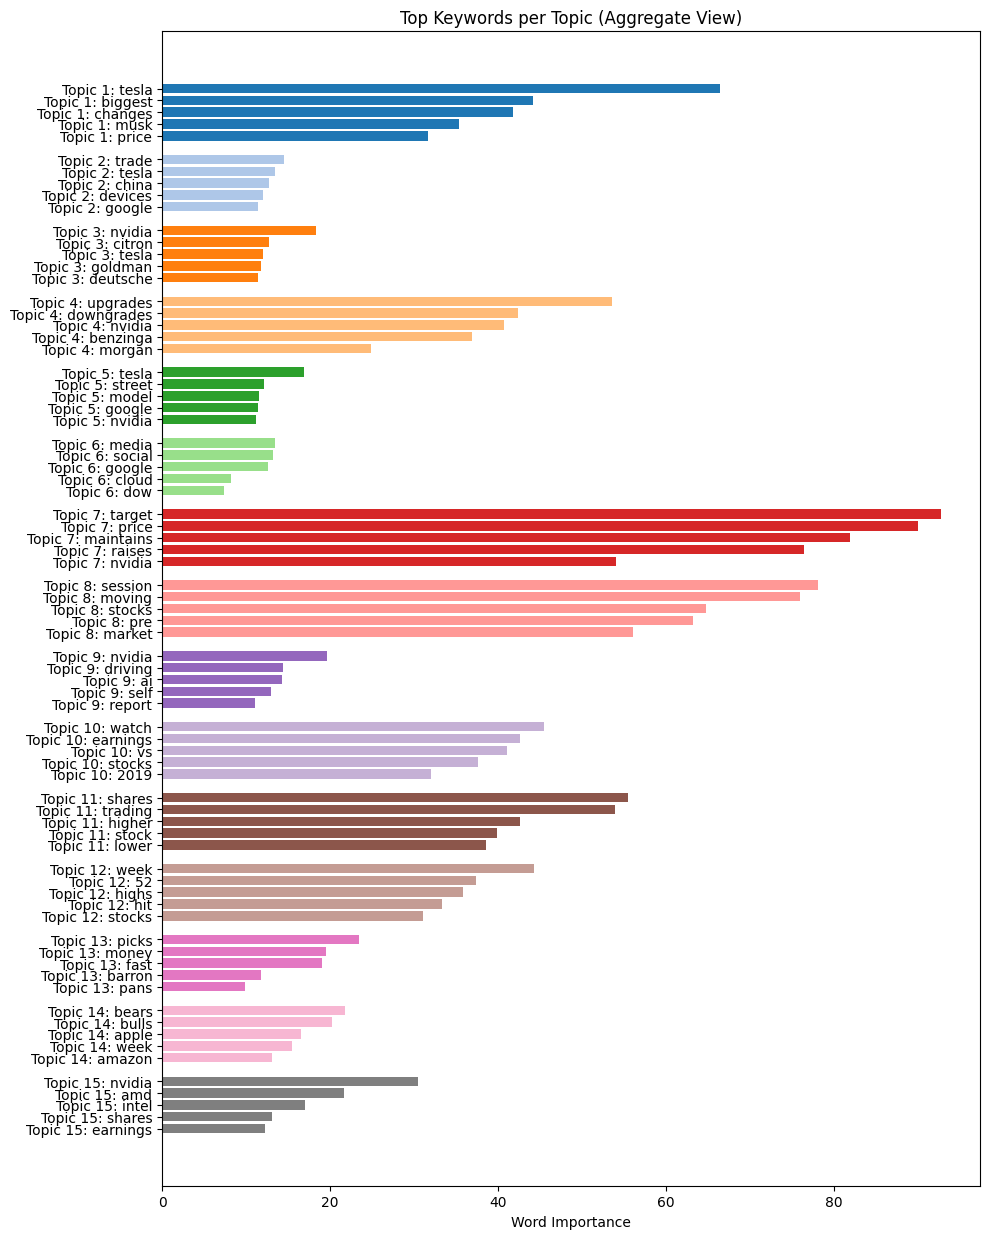

In [9]:
n_show = 5  # Number of keywords to show per topic
n_topics = len(topics)

fig, ax = plt.subplots(figsize=(10, n_topics * 0.7 + 2))

yticks = []
ylabels = []
bar_colors = plt.cm.tab20.colors  # For color variety

for topic_idx, topic_words in enumerate(topics):
    topic_weights = lda_model.components_[topic_idx]
    top_indices = np.argsort(topic_weights)[::-1][:n_show]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = topic_weights[top_indices]
    y = np.arange(len(top_words)) + topic_idx * (n_show + 1)
    ax.barh(y, top_scores, color=bar_colors[topic_idx % len(bar_colors)], label=f"Topic {topic_idx+1}")
    yticks.extend(y)
    ylabels.extend([f"Topic {topic_idx+1}: {w}" for w in top_words])

ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.invert_yaxis()
ax.set_xlabel("Word Importance")
ax.set_title("Top Keywords per Topic (Aggregate View)")
plt.tight_layout()
plt.show()

## Frequency of Specific Events

The bar chart below shows how often each type of significant event (such as earnings, FDA approvals, leadership changes, and product launches) appears in our news headlines. This helps us understand which events are most frequently reported and may have the greatest impact on market sentiment.

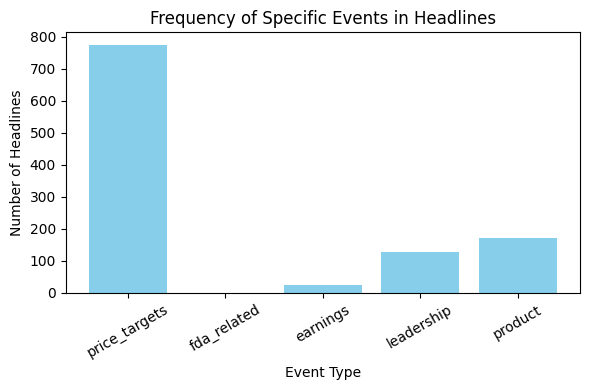

In [10]:
# Simple bar plot for event frequency
plt.figure(figsize=(6, 4))
plt.bar(event_counts.keys(), event_counts.values(), color='skyblue')
plt.ylabel("Number of Headlines")
plt.xlabel("Event Type")
plt.title("Frequency of Specific Events in Headlines")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()